In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, ttest_ind

In [2]:
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8, 5)
os.makedirs("figures", exist_ok=True)



In [3]:
df = sns.load_dataset("titanic")

print("=== Head ===")
print(df.head(), "\n")

print("=== Info ===")
print(df.info(), "\n")

print("=== Describe (numeric) ===")
print(df.describe(), "\n")

print("=== Describe (include all) ===")
print(df.describe(include="all"), "\n")

=== Head ===
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True   

=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   


In [4]:
print("=== Column list ===")
print(df.columns.tolist(), "\n")

print("=== Target variable ===")
print("survived: 0 = died, 1 = survived\n")

print("=== Shape ===")
print(df.shape, "\n")

=== Column list ===
['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'] 

=== Target variable ===
survived: 0 = died, 1 = survived

=== Shape ===
(891, 15) 



=== Missing values per column ===
deck           688
age            177
embarked         2
embark_town      2
sex              0
pclass           0
survived         0
fare             0
parch            0
sibsp            0
class            0
adult_male       0
who              0
alive            0
alone            0
dtype: int64 



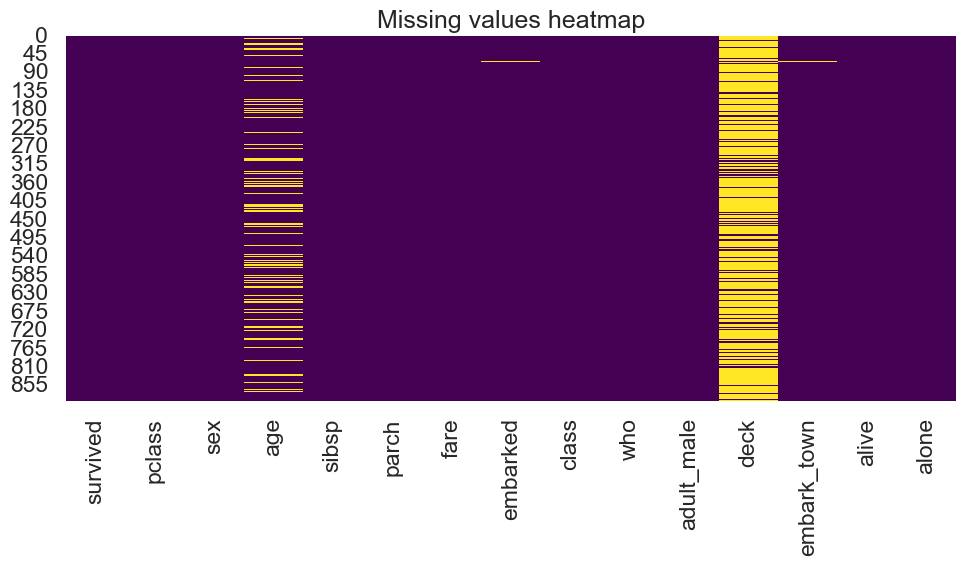

In [5]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("=== Missing values per column ===")
print(missing_counts, "\n")

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing values heatmap")
plt.tight_layout()
plt.savefig("figures/01_missing_heatmap.png")
plt.show()


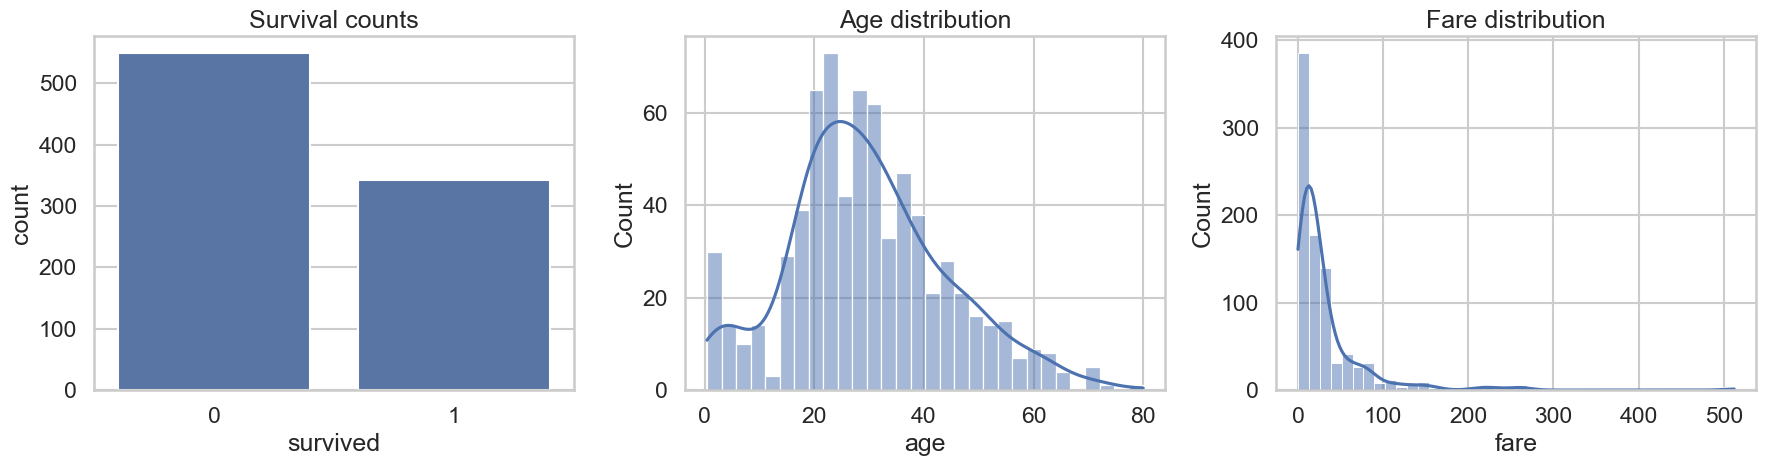

=== Survival rate (mean) ~ 0.38 ===



In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(x="survived", data=df, ax=axes[0])
axes[0].set_title("Survival counts")

sns.histplot(df["age"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Age distribution")

sns.histplot(df["fare"], bins=40, kde=True, ax=axes[2])
axes[2].set_title("Fare distribution")

plt.tight_layout()
plt.savefig("figures/02_univariate.png")
plt.show()

survival_rate = df["survived"].mean()
print(f"=== Survival rate (mean) ~ {survival_rate:.2f} ===\n")


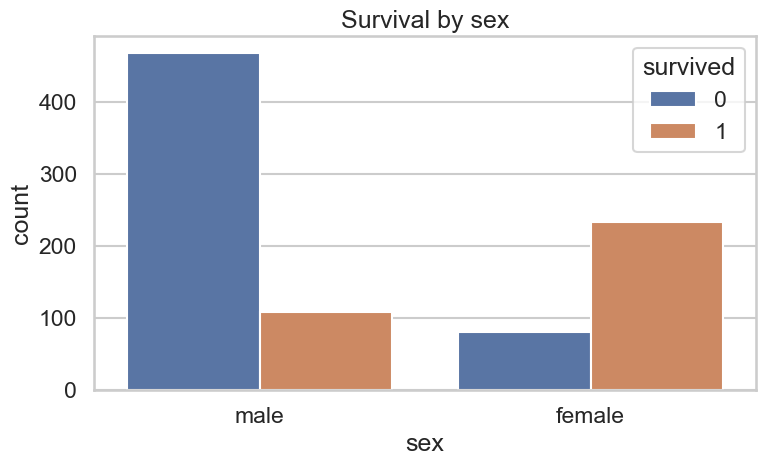

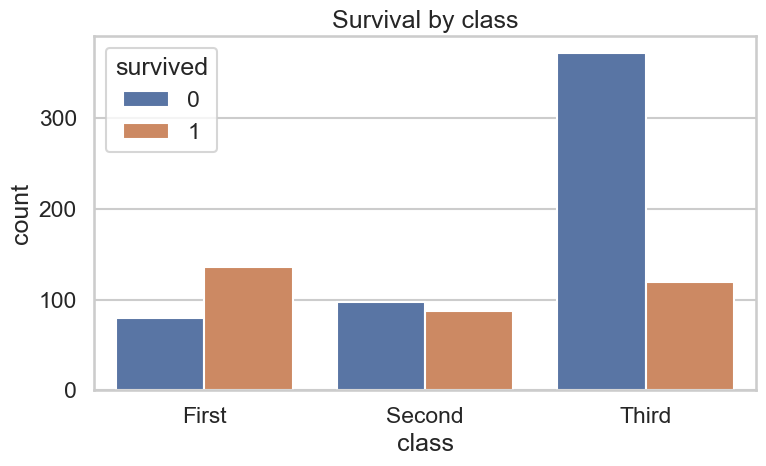

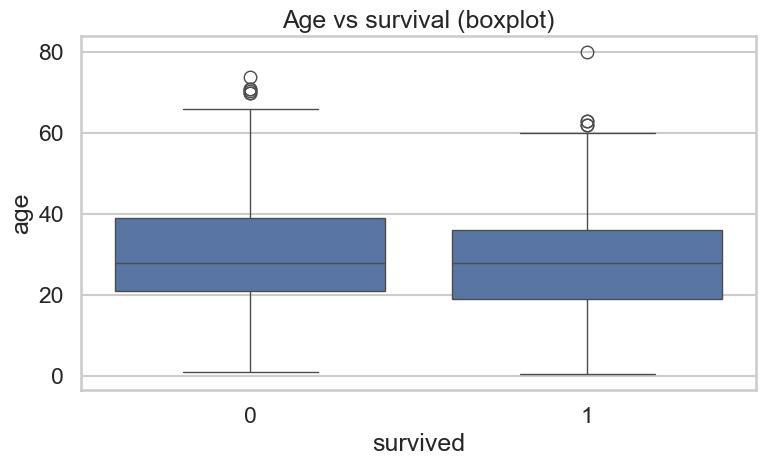

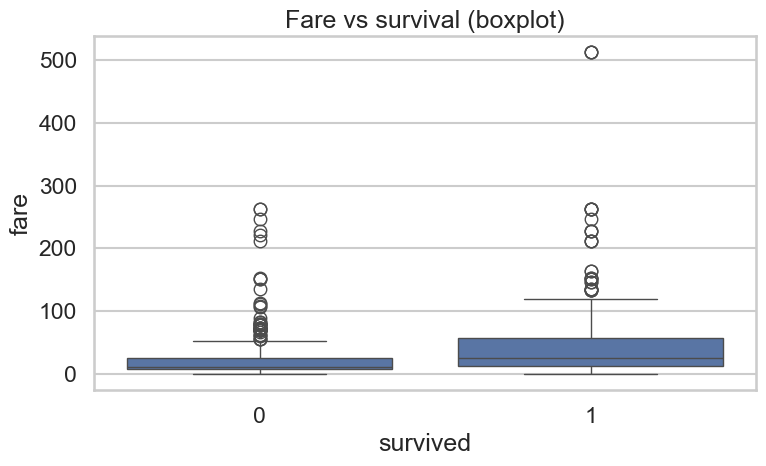

In [7]:
plt.figure()
sns.countplot(x="sex", hue="survived", data=df)
plt.title("Survival by sex")
plt.tight_layout()
plt.savefig("figures/03_survival_by_sex.png")
plt.show()

plt.figure()
sns.countplot(x="class", hue="survived", data=df)
plt.title("Survival by class")
plt.tight_layout()
plt.savefig("figures/04_survival_by_class.png")
plt.show()

plt.figure()
sns.boxplot(x="survived", y="age", data=df)
plt.title("Age vs survival (boxplot)")
plt.tight_layout()
plt.savefig("figures/05_age_vs_survival.png")
plt.show()

plt.figure()
sns.boxplot(x="survived", y="fare", data=df)
plt.title("Fare vs survival (boxplot)")
plt.tight_layout()
plt.savefig("figures/06_fare_vs_survival.png")
plt.show()


In [8]:
df_fe = df.copy()

# a) Impute age with group-wise median for 'who' (man/woman/child) to preserve structure
#    If group median is NaN, fallback to overall median
group_medians = df_fe.groupby("who")["age"].median()
overall_median_age = df_fe["age"].median()
df_fe["age"] = df_fe.apply(
    lambda row: group_medians[row["who"]] if pd.notnull(row["who"]) and pd.isnull(row["age"]) else row["age"],
    axis=1
)
df_fe["age"] = df_fe["age"].fillna(overall_median_age)

# b) Fill embark_town with mode
if df_fe["embark_town"].isnull().any():
    df_fe["embark_town"] = df_fe["embark_town"].fillna(df_fe["embark_town"].mode()[0])

# c) Replace deck NaNs with 'Unknown' (categorical treatment)
df_fe["deck"] = df_fe["deck"].astype("object").fillna("Unknown")

# d) Family size and solitude
df_fe["family_size"] = df_fe["sibsp"] + df_fe["parch"] + 1
df_fe["is_alone"] = (df_fe["family_size"] == 1).astype(int)

# e) Age groups (bins)
df_fe["age_group"] = pd.cut(
    df_fe["age"],
    bins=[0, 12, 18, 35, 60, 100],
    labels=["Child", "Teen", "Young Adult", "Adult", "Senior"]
)

print("=== After cleaning: missing values check ===")
print(df_fe.isnull().sum().sort_values(ascending=False), "\n")



=== After cleaning: missing values check ===
embarked       2
survived       0
pclass         0
sex            0
sibsp          0
age            0
parch          0
fare           0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
family_size    0
is_alone       0
age_group      0
dtype: int64 



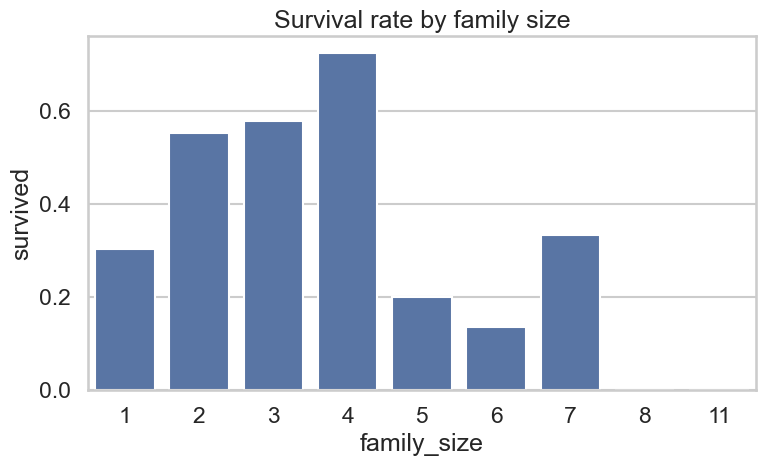

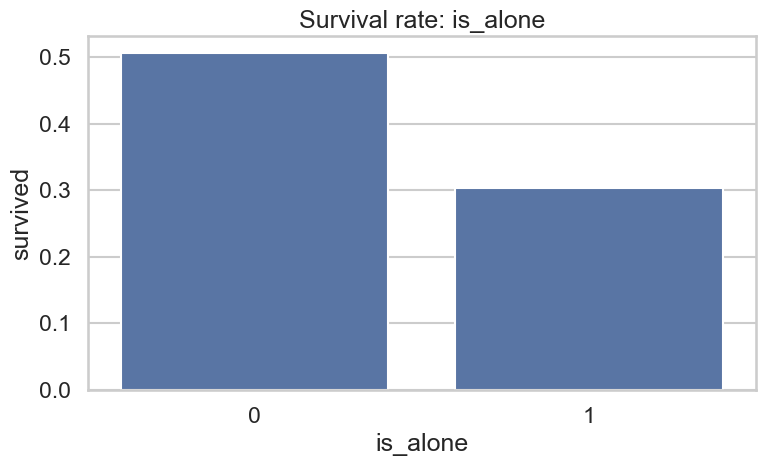

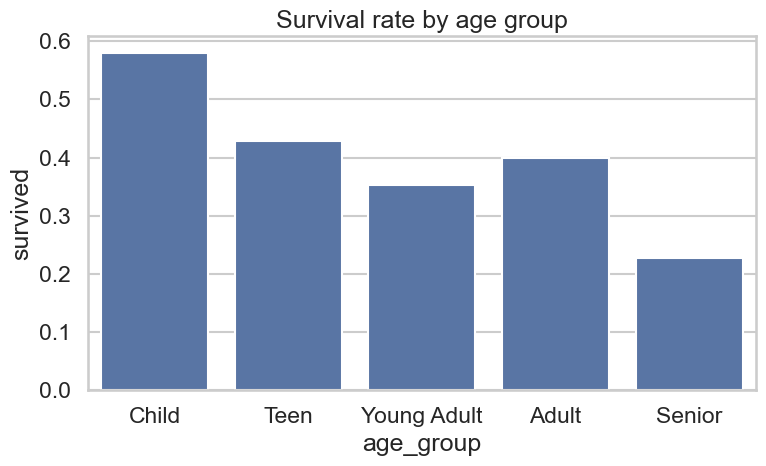

In [9]:
plt.figure()
sns.barplot(x="family_size", y="survived", data=df_fe, estimator=np.mean, errorbar=None)
plt.title("Survival rate by family size")
plt.tight_layout()
plt.savefig("figures/07_survival_by_family_size.png")
plt.show()

plt.figure()
sns.barplot(x="is_alone", y="survived", data=df_fe, estimator=np.mean, errorbar=None)
plt.title("Survival rate: is_alone")
plt.tight_layout()
plt.savefig("figures/08_survival_by_is_alone.png")
plt.show()

plt.figure()
sns.barplot(x="age_group", y="survived", data=df_fe, estimator=np.mean, errorbar=None)
plt.title("Survival rate by age group")
plt.tight_layout()
plt.savefig("figures/09_survival_by_age_group.png")
plt.show()



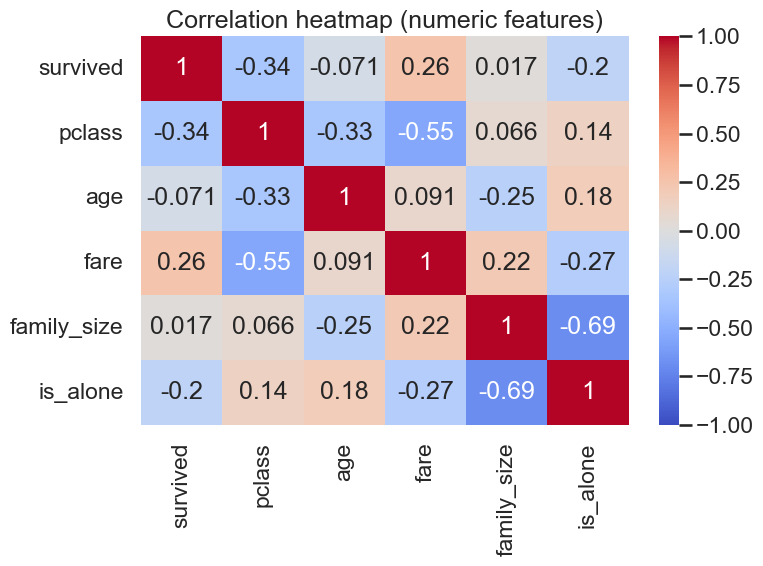

=== Correlation with survived ===
survived       1.000000
fare           0.257307
family_size    0.016639
age           -0.070657
is_alone      -0.203367
pclass        -0.338481
Name: survived, dtype: float64 



In [10]:
corr_cols = ["survived", "pclass", "age", "fare", "family_size", "is_alone"]
corr_matrix = df_fe[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.savefig("figures/10_correlation_heatmap.png")
plt.show()

print("=== Correlation with survived ===")
print(corr_matrix["survived"].sort_values(ascending=False), "\n")



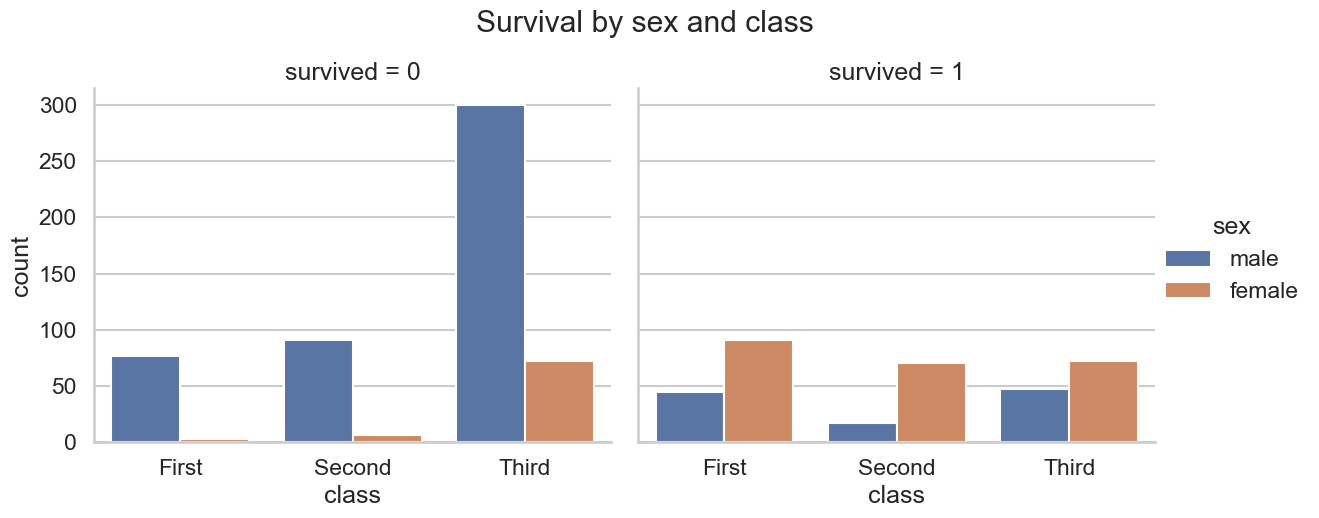

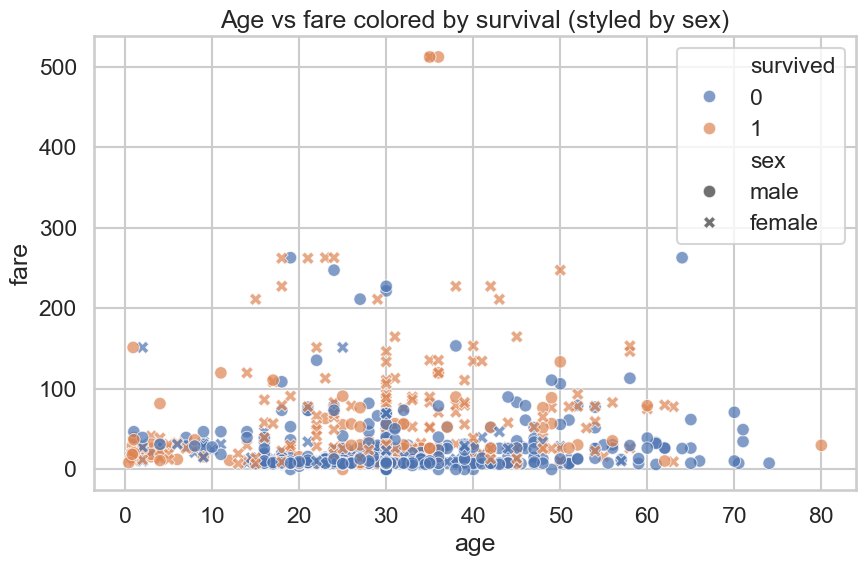

In [11]:
sns.catplot(x="class", hue="sex", col="survived", kind="count", data=df_fe, height=5, aspect=1.2)
plt.suptitle("Survival by sex and class", y=1.05)
plt.savefig("figures/11_survival_by_sex_and_class.png")
plt.show()

plt.figure(figsize=(9, 6))
sns.scatterplot(x="age", y="fare", hue="survived", style="sex", data=df_fe, alpha=0.7)
plt.title("Age vs fare colored by survival (styled by sex)")
plt.tight_layout()
plt.savefig("figures/12_age_fare_survival.png")
plt.show()



In [12]:
# a) Sex vs survival (Chi-square for independence)
contingency_sex = pd.crosstab(df_fe["sex"], df_fe["survived"])
chi2_sex, p_sex, dof_sex, expected_sex = chi2_contingency(contingency_sex)
print("=== Chi-square (Sex vs Survival) ===")
print(f"chi2={chi2_sex:.3f}, p-value={p_sex:.6f}, dof={dof_sex}")
print("Expected frequencies:\n", pd.DataFrame(expected_sex, index=contingency_sex.index, columns=contingency_sex.columns), "\n")

# b) Class vs survival (Chi-square)
contingency_class = pd.crosstab(df_fe["class"], df_fe["survived"])
chi2_class, p_class, dof_class, expected_class = chi2_contingency(contingency_class)
print("=== Chi-square (Class vs Survival) ===")
print(f"chi2={chi2_class:.3f}, p-value={p_class:.6f}, dof={dof_class}")
print("Expected frequencies:\n", pd.DataFrame(expected_class, index=contingency_class.index, columns=contingency_class.columns), "\n")

# c) Age vs survival (independent t-test on numeric age)
survived_age = df_fe[df_fe["survived"] == 1]["age"].dropna()
died_age = df_fe[df_fe["survived"] == 0]["age"].dropna()
t_stat_age, p_val_age = ttest_ind(survived_age, died_age, equal_var=False)  # Welch's t-test
print("=== t-test (Age vs Survival) ===")
print(f"t-stat={t_stat_age:.3f}, p-value={p_val_age:.6f}\n")

=== Chi-square (Sex vs Survival) ===
chi2=260.717, p-value=0.000000, dof=1
Expected frequencies:
 survived           0           1
sex                             
female    193.474747  120.525253
male      355.525253  221.474747 

=== Chi-square (Class vs Survival) ===
chi2=102.889, p-value=0.000000, dof=2
Expected frequencies:
 survived           0           1
class                           
First     133.090909   82.909091
Second    113.373737   70.626263
Third     302.535354  188.464646 

=== t-test (Age vs Survival) ===
t-stat=-2.063, p-value=0.039484



In [13]:
print("=== Key aggregated insights ===")
print(f"- Overall survival rate: {df_fe['survived'].mean():.2f}")
print(f"- Survival by sex:\n{df_fe.groupby('sex')['survived'].mean()}\n")
print(f"- Survival by class:\n{df_fe.groupby('class')['survived'].mean()}\n")
print(f"- Survival by is_alone:\n{df_fe.groupby('is_alone')['survived'].mean()}\n")
print(f"- Survival by age_group:\n{df_fe.groupby('age_group')['survived'].mean()}\n")
print("- Correlations suggest higher fare and lower pclass (1st class) relate to higher survival.")
print("- Chi-square p-values for sex and class vs survival are typically < 0.001 (strong association).")
print("- t-test indicates age distributions between survivors and non-survivors differ statistically (p < 0.05).")

print("\nAll key figures saved in ./figures — ready for your report.")


=== Key aggregated insights ===
- Overall survival rate: 0.38
- Survival by sex:
sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

- Survival by class:
class
First     0.629630
Second    0.472826
Third     0.242363
Name: survived, dtype: float64

- Survival by is_alone:
is_alone
0    0.505650
1    0.303538
Name: survived, dtype: float64

- Survival by age_group:
age_group
Child          0.579710
Teen           0.428571
Young Adult    0.353271
Adult          0.400000
Senior         0.227273
Name: survived, dtype: float64

- Correlations suggest higher fare and lower pclass (1st class) relate to higher survival.
- Chi-square p-values for sex and class vs survival are typically < 0.001 (strong association).
- t-test indicates age distributions between survivors and non-survivors differ statistically (p < 0.05).

All key figures saved in ./figures — ready for your report.
